## DS5559 - Project
## Notebook 9 - Sentiment Analysis
### Novel: *Pride and Prejudice* by Jane Austen
#### Name: Mengyao Zhang (mz6jv), Runhao Zhao (rz6dg)

# Synopsis

Applying Syuzhet methods to *Pride and Prejudice* by Jane Austen using NRC, Bing, Syuzhet.

# Configuration

In [102]:
# Developed in other notebook
lex_db = 'lexicons.db'

# Developed in previous notebooks
text_db = 'project.db'
OHCO = ['book_num','chap_num', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1] 
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

novel_1 = '12' # pride and prejudice

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

# Libraries

In [103]:
import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

# Pragmas

In [104]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# Process

## Get Lexicons

In [105]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [106]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


### Get lexicon columns

In [107]:
# emo_cols = [col for col in combo.columns if 'nrc_' in col]
emo_cols = combo.columns

In [108]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

## Analyze Pride and Prejudice 

## Get Text

In [109]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE book_num = {} AND punc = 0".format(novel_1), db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

### Merge sentiment lexicon with vocab

In [110]:
tokens = tokens.join(combo, on='term_str', how='left')

In [111]:
tokens

pos     token_str  punc  num  \
book_num chap_num para_num sent_num token_num                                  
12       0        0        0        0            NN   ClassicBook     0    0   
                                    1            CD            12     0    1   
         1        0        0        0            NN       Chapter     0    0   
                                    1            CD             1     0    1   
                  1        0        0           PRP            It     0    0   
                                    1           VBZ            is     0    0   
                                    2            DT             a     0    0   
                                    3            NN         truth     0    0   
                                    4            RB   universally     0    0   
                                    5           VBD  acknowledged     0    0   
                                    7            IN          that     0    0   
                                    8            DT             a     0    0   
                                    9            JJ        single     0    0   
                                    10           NN           man     0    0   
                                    11           IN            in     0    0   
                                    12           NN    possession     0    0   
                                    13           IN            of     0    0   
                                    14           DT             a     0    0   
                                    15           JJ          good     0    0   
                                    16           NN       fortune     0    0   
                                    18           MD          must     0    0   
                                    19           VB            be     0    0   
                                    20           IN            in     0    0   
                                    21           NN          want     0    0   
                                    22           IN            of     0    0   
                                    23           DT             a     0    0   
                                    24           NN          wife     0    0   
                  2        0        0            RB       However     0    0   
                                    1            JJ        little     0    0   
                                    2           VBN         known     0    0   
...                                             ...           ...   ...  ...   
         61       15       1        5           NNP     Elizabeth     0    0   
                                    7            RB        really     0    0   
                                    8           VBD         loved     0    0   
                                    9           PRP          them     0    0   
                                    11           CC           and     0    0   
                                    12          PRP          they     0    0   
                                    13          VBD          were     0    0   
                                    14           DT          both     0    0   
                                    15           RB          ever     0    0   
                                    16           NN      sensible     0    0   
                                    17           IN            of     0    0   
                                    18           DT           the     0    0   
                                    19          JJS       warmest     0    0   
                                    20           NN     gratitude     0    0   
                                    21           IN       towards     0    0   
                                    22           DT           the     0    0   
                                    23          NNS       persons     0    0   
                                    24          

In [112]:
tokens[emo].sample(10)

book_num  chap_num  para_num  sent_num  token_num
12        10        42        2         30            NaN
          16        2         0         104           NaN
          1         32        0         19           0.40
          11        2         1         15            NaN
          59        19        3         2             NaN
          60        13        5         1             NaN
          6         39        0         1             NaN
                    24        1         42            NaN
          15        11        1         30            NaN
          58        3         0         9           -0.25
Name: syu_sentiment, dtype: float64

In [113]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [114]:
tokens.head(10)

pos     token_str  punc  num  \
book_num chap_num para_num sent_num token_num                                 
12       0        0        0        0           NN   ClassicBook     0    0   
                                    1           CD            12     0    1   
         1        0        0        0           NN       Chapter     0    0   
                                    1           CD             1     0    1   
                  1        0        0          PRP            It     0    0   
                                    1          VBZ            is     0    0   
                                    2           DT             a     0    0   
                                    3           NN         truth     0    0   
                                    4           RB   universally     0    0   
                                    5          VBD  acknowledged     0    0   

                                                   term_str  term_id  \
book_num chap_num para_num sent_num token_num                          
12       0        0        0        0           classicbook     6874   
                                    1                  None       -1   
         1        0        0        0               chapter     6192   
                                    1                  None       -1   
                  1        0        0                    it    21536   
                                    1                    is    21498   
                                    2                     a       12   
                                    3                 truth    40701   
                                    4           universally    41765   
                                    5          acknowledged      366   

                                               nrc_anger  nrc_anticipation  \
book_num chap_num para_num sent_num token_num                                
12       0        0        0        0                0.0               0.0   
                                    1                0.0               0.0   
         1        0        0        0                0.0               0.0   
                                    1                0.0               0.0   
                  1        0        0                0.0               0.0   
                                    1                0.0               0.0   
                                    2                0.0               0.0   
                                    3                0.0               0.0   
                                    4                0.0               0.0   
                                    5                0.0               0.0   

                                               nrc_disgust  nrc_fear  \
book_num chap_num para_num sent_num token_num                          
12       0        0        0        0                  0.0       0.0   
                                    1                  0.0       0.0   
         1        0        0        0                  0.0       0.0   
                                    1                  0.0       0.0   
                  1        0        0                  0.0       0.0   
                                    1                  0.0       0.0   
                                    2                  0.0       0.0   
                                    3                  0.0       0.0   
                                    4                  0.0       0.0   
                                    5                  0.0       0.0   

                                                   ...       nrc_negative  \
book_num chap_num para_num sent_num token_num      ...                      
12       0        0        0        0              ...                0.0   
                                    1              ...                0.0   
         1        0        0        0              ...                0.0   
                                    1         

## Sentiment by OHCO

In [115]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

### By Chapter

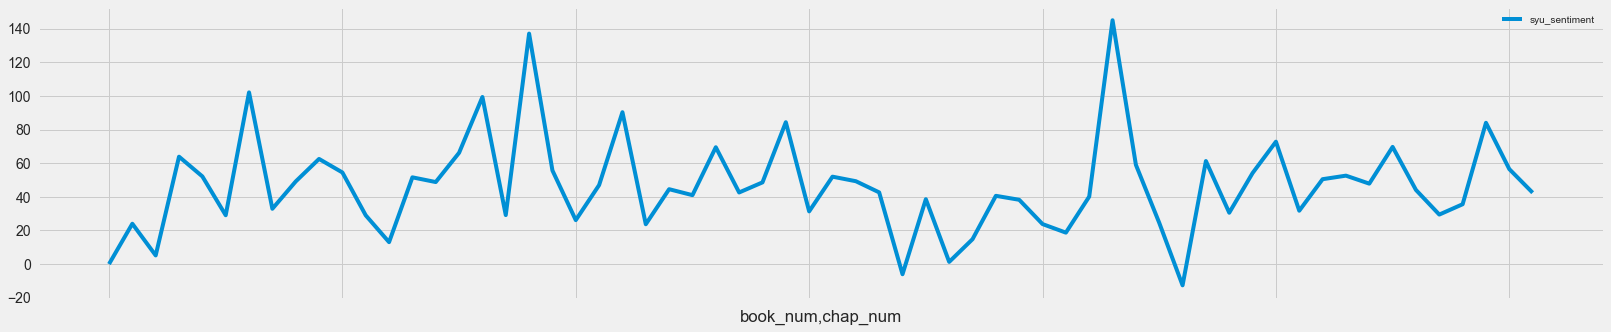

In [116]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

### By Paragraph

In [117]:
by_para = tokens.groupby(PARAS)[emo_cols].sum()

In [118]:
max_x = by_para.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

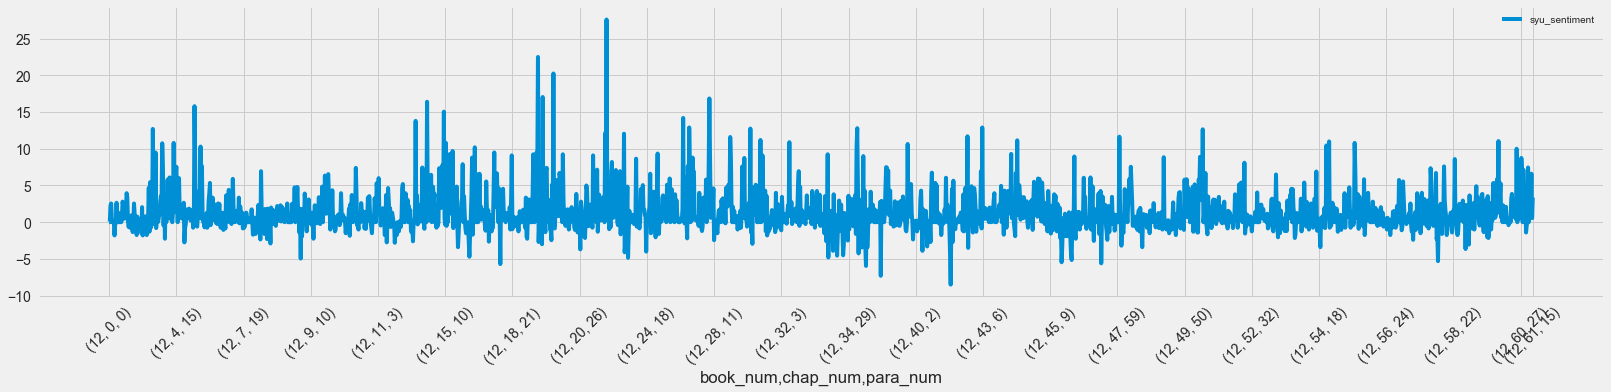

In [119]:
by_para[emo].plot(**FIG, xticks=xticks)

### By Sentence

In [120]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()

In [121]:
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)

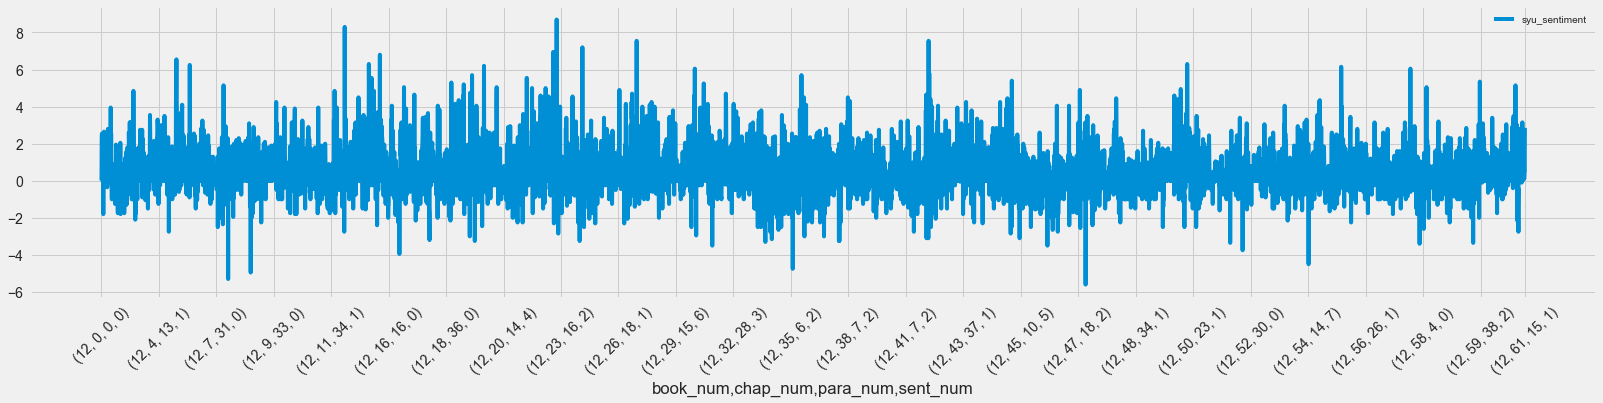

In [122]:
by_sent[emo].plot(**FIG, xticks=xticks)

### Add text to do spot checks

In [123]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [124]:
tokens['html'].head()

book_num  chap_num  para_num  sent_num  token_num
12        0         0         0         0            <span class='sent0'>ClassicBook</span>
                                        1                     <span class='sent0'>12</span>
          1         0         0         0                <span class='sent0'>Chapter</span>
                                        1                      <span class='sent0'>1</span>
                    1         0         0                     <span class='sent0'>It</span>
Name: html, dtype: object

In [125]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [126]:
by_sent[['sent_str', 'html_str']].head()

sent_str  \
book_num chap_num para_num sent_num                                                      
12       0        0        0                                               classicbook   
         1        0        0                                                   chapter   
                  1        0         it is a truth universally acknowledged that a ...   
                  2        0         however little known the feelings or views of ...   
                  3        0         my dear mr. bennet said his lady to him one da...   

                                                                              html_str  
book_num chap_num para_num sent_num                                                     
12       0        0        0         <span class='sent0'>ClassicBook</span> <span c...  
         1        0        0         <span class='sent0'>Chapter</span> <span class...  
                  1        0         <span class='sent0'>It</span> <span class='sen...  
                  2        0         <span class='sent0'>However</span> <span class...  
                  3        0         <span class='sent0'>My</span> <span class='sen...

### Histogram

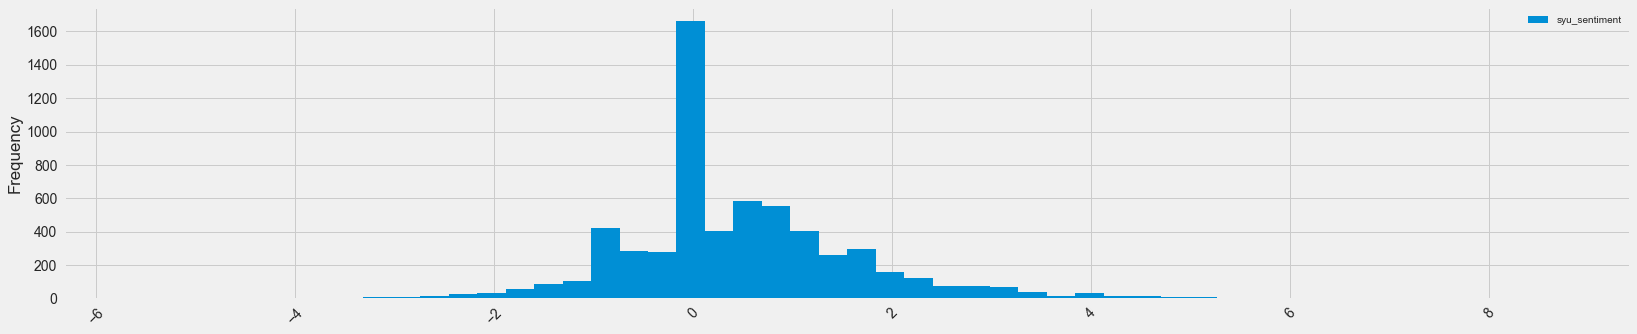

In [127]:
by_sent[emo].plot.hist(**FIG, bins=50)

### Look at a sample of sentences

In [128]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

Sentiment,ID,Sentence
0.5,"(12, 53, 37, 1)",But she would not be secure
0.6,"(12, 24, 11, 7)",I have met with two instances lately one I will not mention the other is Charlotte s marriage
1.0,"(12, 18, 49, 1)",I am satisfied
0.25,"(12, 18, 9, 1)",That reply will do for the present
-0.5,"(12, 7, 21, 0)",Dining out said Mrs. Bennet that is very unlucky
1.6,"(12, 18, 56, 0)",Elizabeth tried hard to dissuade him from such a scheme assuring him that Mr. Darcy would consider his addressing him without introduction as an impertinent freedom rather than a compliment to his aunt that it was not in the least necessary there should be any notice on either side and that if it were it must belong to Mr. Darcy the superior in consequence to begin the acquaintance
1.75,"(12, 55, 52, 1)",Till I have your disposition your goodness I never can have your happiness
0.0,"(12, 52, 20, 1)",GARDINER
0.25,"(12, 53, 22, 0)",As soon as ever Mr. Bingley comes my dear said Mrs. Bennet you will wait on him of course
1.55,"(12, 47, 62, 8)",I shall send for my clothes when I get to Longbourn but I wish you would tell Sally to mend a great slit in my worked muslin gown before they are packed up


### Plot with Xticks

In [129]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

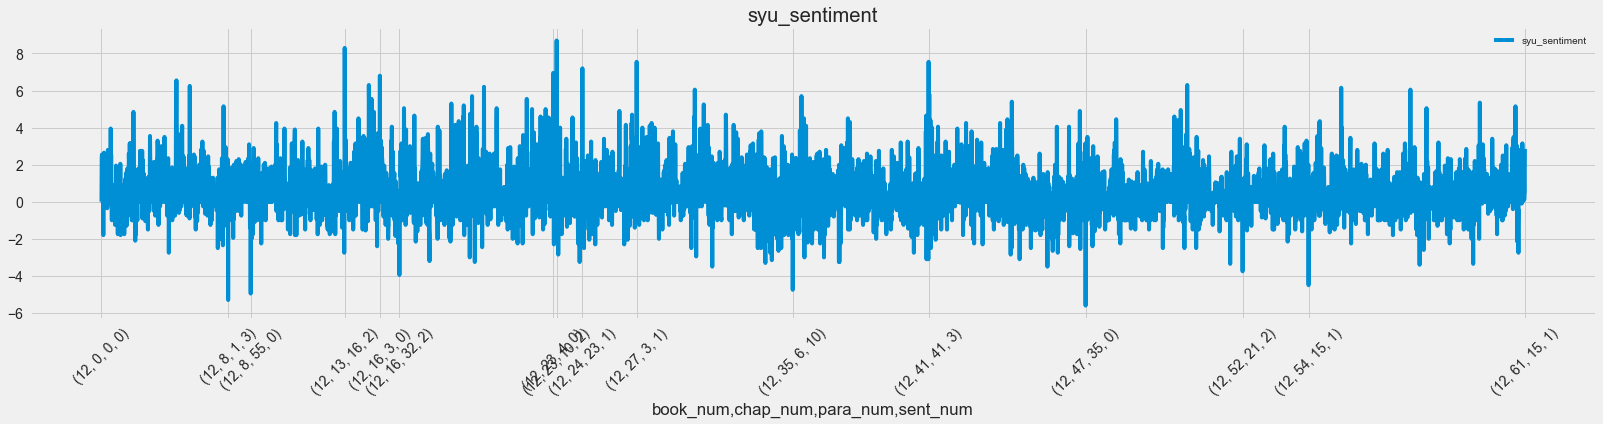

In [130]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

In [131]:
by_sent.iloc[xticks][emo].sort_index().to_frame()

syu_sentiment
book_num chap_num para_num sent_num               
12       0        0        0                  0.00
         8        1        3                 -5.30
                  55       0                 -4.95
         13       16       2                  8.30
         16       3        0                  6.80
                  32       2                 -3.95
         23       4        0                  6.95
                  10       2                  8.70
         24       23       1                  7.20
         27       3        1                  7.55
         35       6        10                -4.75
         41       41       3                  7.55
         47       35       0                 -5.60
         52       21       2                 -3.75
         54       15       1                 -4.50
         61       15       1                  2.85

### Inspect Positives

In [132]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

syu_sentiment  \
book_num chap_num para_num sent_num                  
12       23       10       2                  8.70   
         13       16       2                  8.30   
         27       3        1                  7.55   
         41       41       3                  7.55   
         24       23       1                  7.20   
         23       4        0                  6.95   
         16       3        0                  6.80   
         6        1        4                  6.55   
         50       15       2                  6.30   
         15       1        2                  6.30   
         6        24       1                  6.25   
         19       9        0                  6.20   
         55       32       2                  6.15   
         30       1        3                  6.05   
         57       16       1                  6.05   
         42       1        1                  5.80   
         35       10       0                  5.70   
         18       66       8                  5.70   
         15       6        2                  5.55   
         21       15       1                  5.55   

                                                                              sent_str  
book_num chap_num para_num sent_num                                                     
12       23       10       2         after discharging his conscience on that head ...  
         13       16       2         my mind however is now made up on the subject ...  
         27       3        1         his present pursuit could not make him forget ...  
         41       41       3         mrs. bennet was diffuse in her good wishes for...  
         24       23       1         they may wish many things besides his happines...  
         23       4        0         elizabeth feeling it incumbent on her to relie...  
         16       3        0         in describing to her all the grandeur of lady ...  
         6        1        4         it was generally evident whenever they met tha...  
         50       15       2         it was an union that must have been to the adv...  
         15       1        2         a fortunate chance had recommended him to lady...  
         6        24       1         elizabeth easy and unaffected had been listene...  
         19       9        0         my reasons for marrying are first that i think...  
         55       32       2         they shook hands with great cordiality and the...  
         30       1        3         elizabeth had at first rather wondered that ch...  
         57       16       1         this young gentleman is blessed in a peculiar ...  
         42       1        1         her father captivated by youth and beauty and ...  
         35       10       0         my excellent father died about five years ago ...  
         18       66       8         many stared many smiled but no one looked more...  
         15       6        2         in his library he had been always sure of leis...  
         21       15       1         i really do not think georgiana darcy has her ...

### Inspect Negatives

In [133]:
by_sent.sort_values(emo, ascending=True)[[emo,'sent_str']].head(20)

syu_sentiment  \
book_num chap_num para_num sent_num                  
12       47       35       0                 -5.60   
         8        1        3                 -5.30   
                  55       0                 -4.95   
         35       6        10                -4.75   
         54       15       1                 -4.50   
         16       32       2                 -3.95   
         52       21       2                 -3.75   
         46       13       0                 -3.50   
         31       15       2                 -3.50   
         57       26       3                 -3.40   
         52       6        14                -3.35   
         59       29       1                 -3.35   
         34       6        0                 -3.30   
         18       70       1                 -3.25   
         24       17       0                 -3.25   
         37       16       2                 -3.25   
                           4                 -3.25   
         18       3        2                 -3.20   
         34       12       2                 -3.15   
         45       10       0                 -3.10   

                                                                              sent_str  
book_num chap_num para_num sent_num                                                     
12       47       35       0         mrs. bennet to whose apartment they all repair...  
         8        1        3         the sisters on hearing this repeated three or ...  
                  55       0         mrs. hurst and miss bingley both cried out aga...  
         35       6        10        if it be so if i have been misled by such erro...  
         54       15       1         anxious and uneasy the period which passed in ...  
         16       32       2         i had supposed him to be despising his fellow ...  
         52       21       2         he had followed them purposely to town he had ...  
         46       13       0           i am grieved indeed cried darcy grieved shocked  
         31       15       2         indeed mr. darcy it is very ungenerous in you ...  
         57       26       3         her father had most cruelly mortified her by w...  
         52       6        14        he confessed himself obliged to leave the regi...  
         59       29       1         she did not fear her father s opposition but h...  
         34       6        0         in spite of her deeply rooted dislike she coul...  
         18       70       1         mrs. hurst and her sister scarcely opened thei...  
         24       17       0         i am far from attributing any part of mr. bing...  
         37       16       2         when she remembered the style of his address s...  
                           4         in her own past behaviour there was a constant...  
         18       3        2         mr. collins awkward and solemn apologising ins...  
         34       12       2         you dare not you can not deny that you have be...  
         45       10       0         in darcy s presence she dared not mention wick...

## Apply Transforms

### Adapt Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. 

In [134]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)

In [135]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

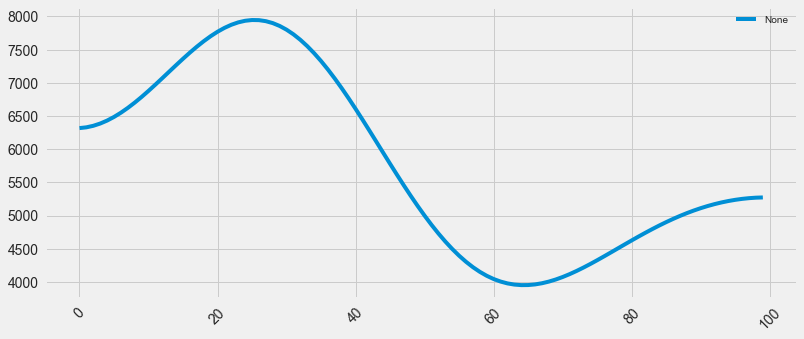

In [136]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [137]:
by_sent.shape

(6194, 17)

In [138]:
# Config for sentences, change window size to 1000
CFG1 = dict(
    win_type='blackman',
    window=1000,
    center=True
)

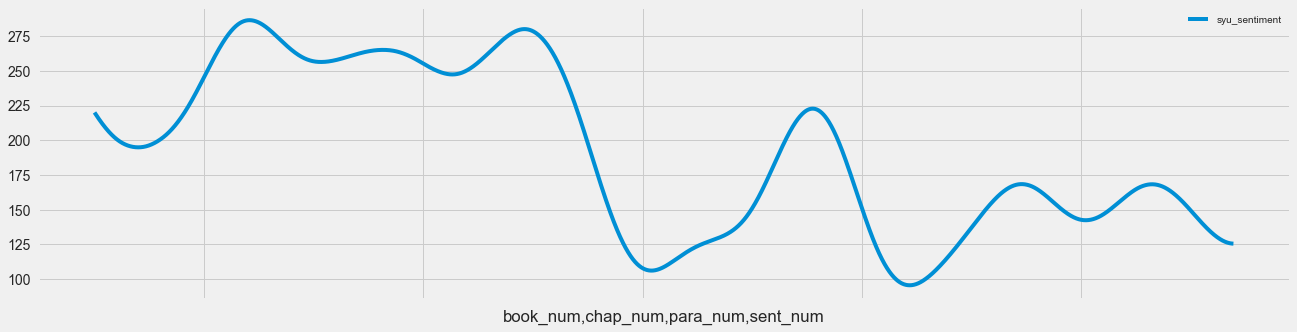

In [139]:
FIG['figsize'] = (20,5)
by_sent[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

In [140]:
# Config for tokens
CFG2 = dict(
    win_type='blackman',
    window= int(tokens.shape[0]/ 10),
    center=True
)
CFG2['window']

12297

In [141]:
tokens.shape

(122976, 22)

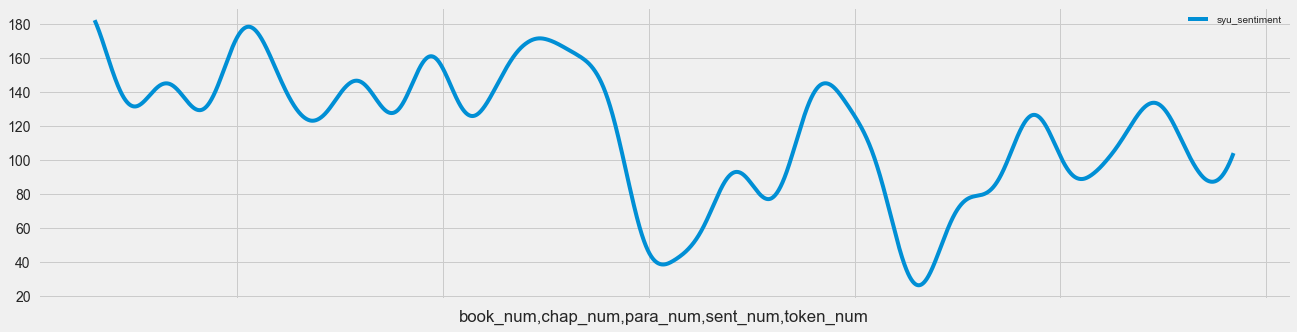

In [142]:
tokens[emo].fillna(0).rolling(**CFG2).sum().plot(**FIG)

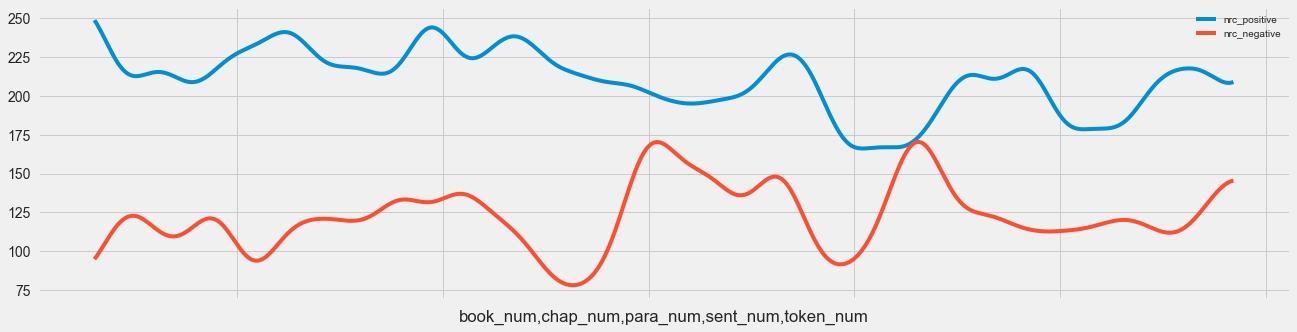

In [143]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG2).sum().plot(**FIG) 
plt.legend()
# pride and prejudice --- positive is higher than negative

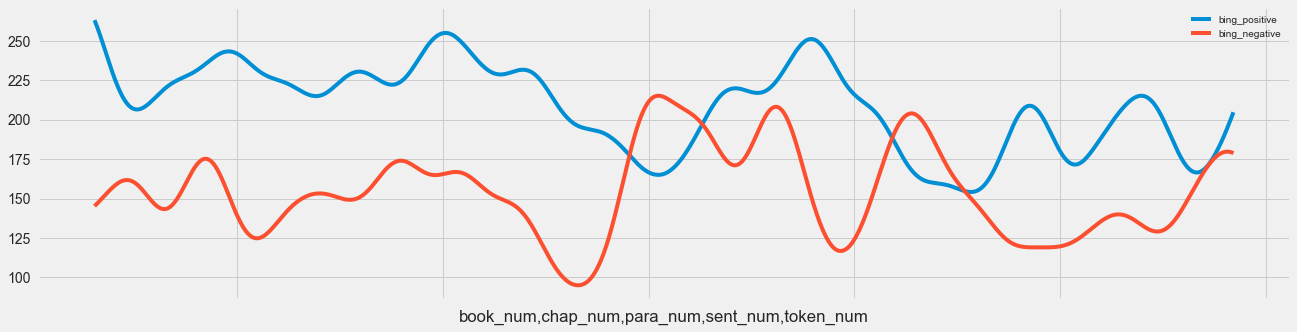

In [144]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG2).sum().plot(**FIG)
plt.legend()
# using bing lexicon also gives similar result

## Multinomial Emotions

In [145]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [146]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


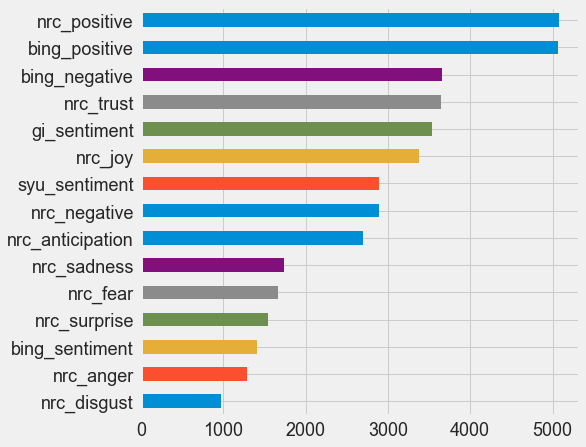

In [147]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)
# positive - high, disgust - low

### Shape data for Sklearn's KDE function

In [148]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [149]:
B

,x
emo,
nrc_anger,"[[15], [149], [216], [660], [829], [1001], [10..."
nrc_anticipation,"[[18], [19], [155], [172], [176], [201], [210]..."
nrc_disgust,"[[15], [216], [641], [660], [829], [1001], [10..."
nrc_fear,"[[15], [151], [216], [660], [677], [829], [838..."
nrc_joy,"[[18], [19], [172], [176], [201], [258], [329]..."
nrc_negative,"[[15], [149], [151], [210], [216], [327], [517..."
nrc_positive,"[[7], [18], [19], [47], [155], [172], [176], [..."
nrc_sadness,"[[327], [517], [660], [683], [950], [1042], [1..."
nrc_surprise,"[[18], [19], [172], [176], [201], [258], [575]..."


### Get KDE for each emotion

In [150]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

### Visualize KDE plots

In [151]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T

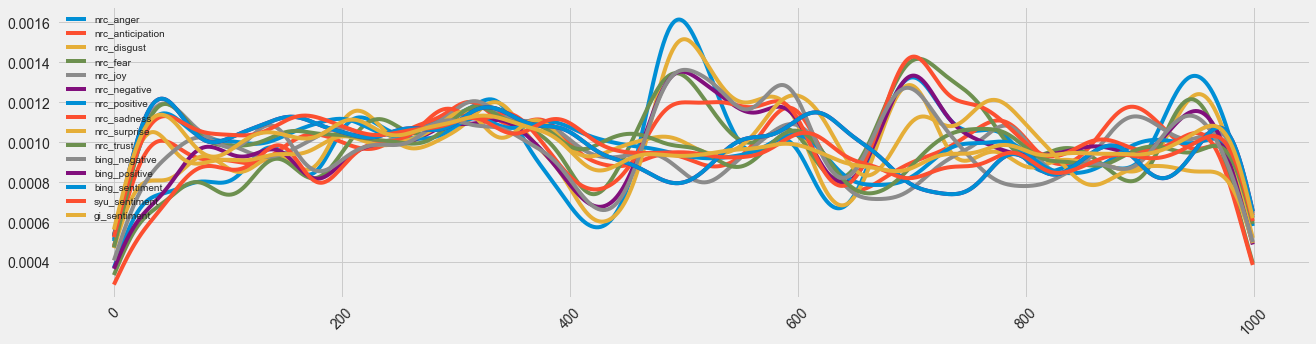

In [152]:
PLOTS.plot(**FIG)
plt.legend()

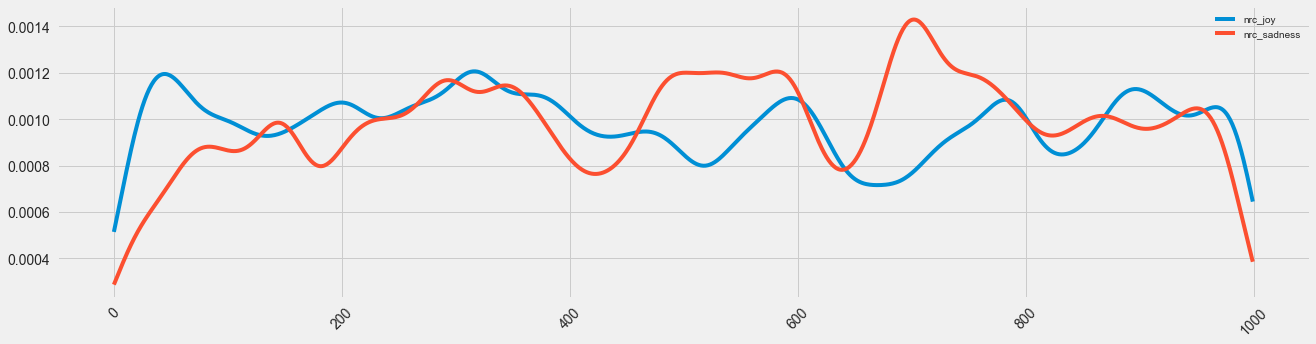

In [153]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)
plt.legend()

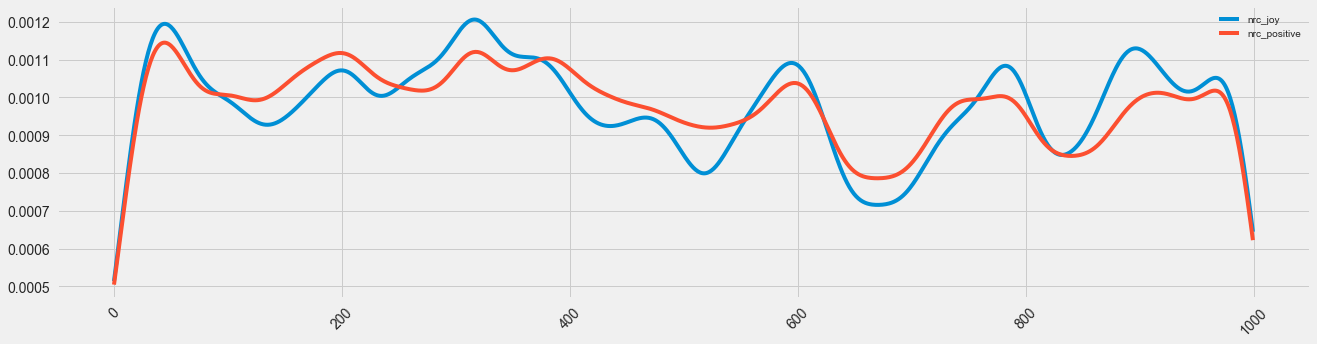

In [154]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)
plt.legend()

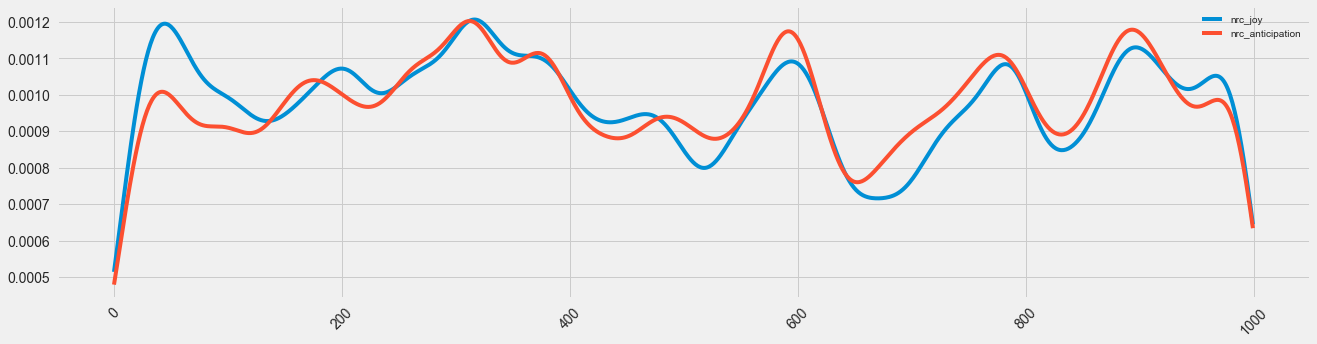

In [155]:
PLOTS[['nrc_joy','nrc_anticipation']].plot(**FIG)
plt.legend()

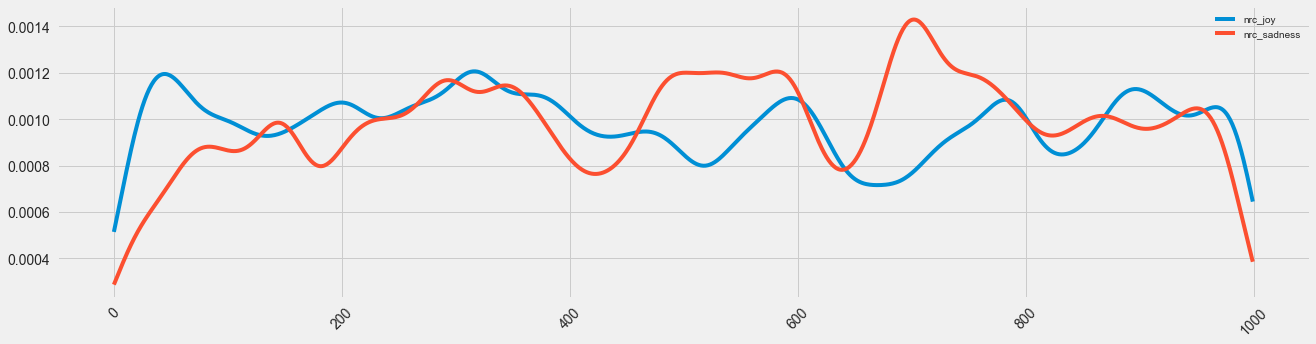

In [156]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)
plt.legend()

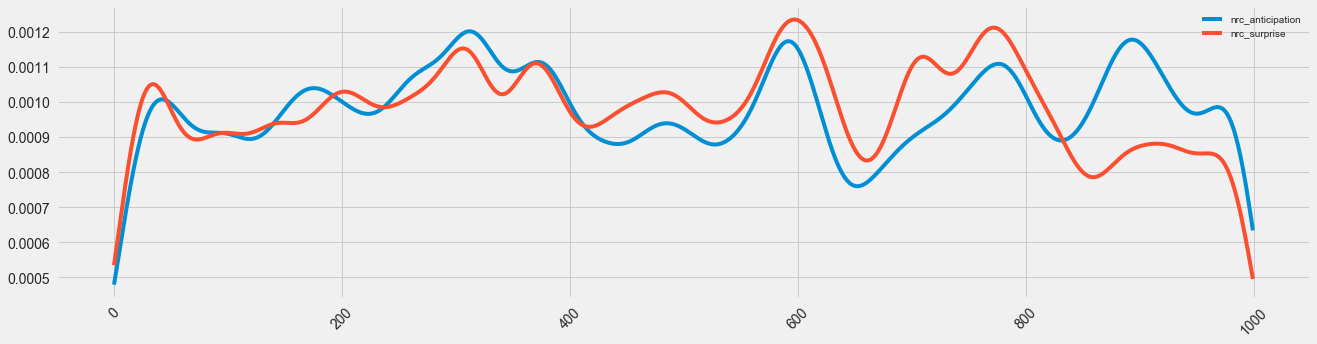

In [157]:
PLOTS[['nrc_anticipation','nrc_surprise']].plot(**FIG)
plt.legend()

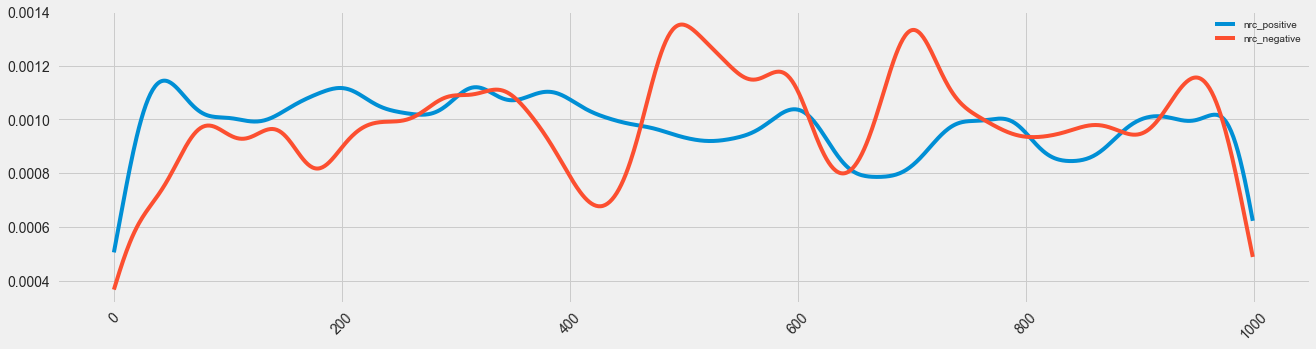

In [158]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)
plt.legend()

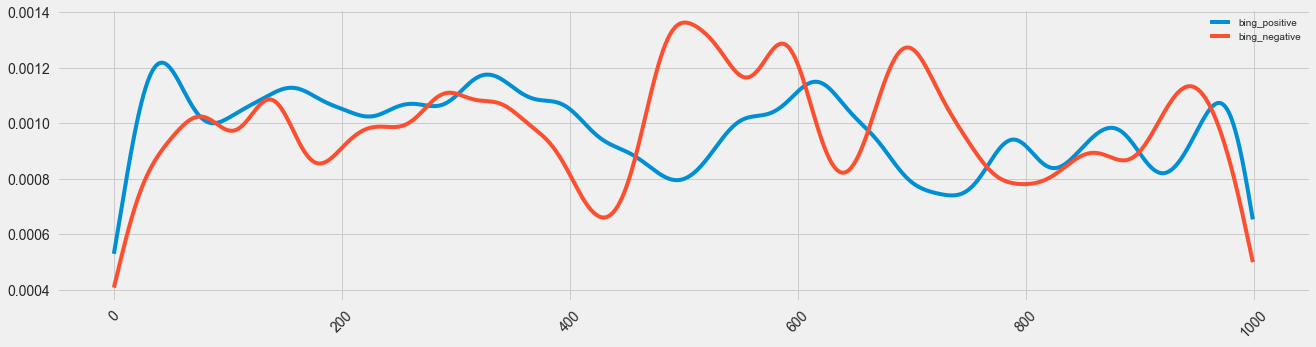

In [159]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)
plt.legend()

### Compare KDE to Rolling graphs of Sentiment

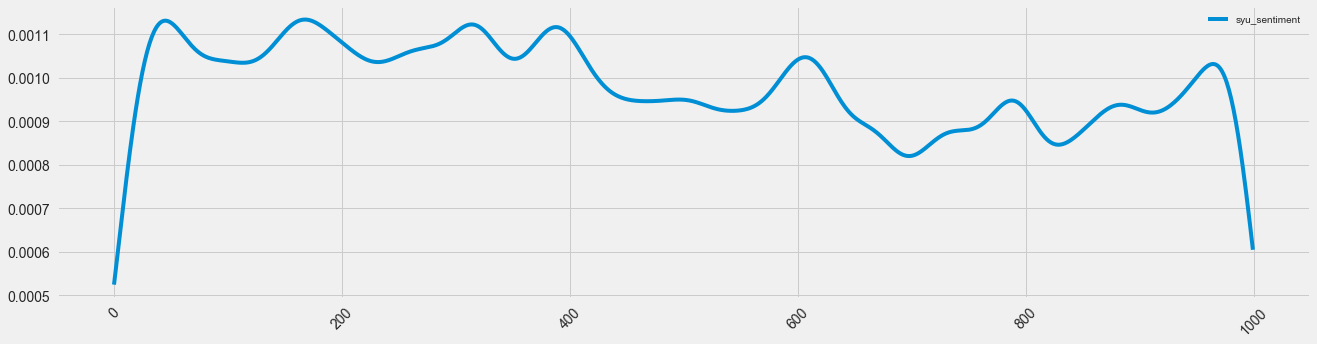

In [160]:
PLOTS[emo].plot(**FIG)

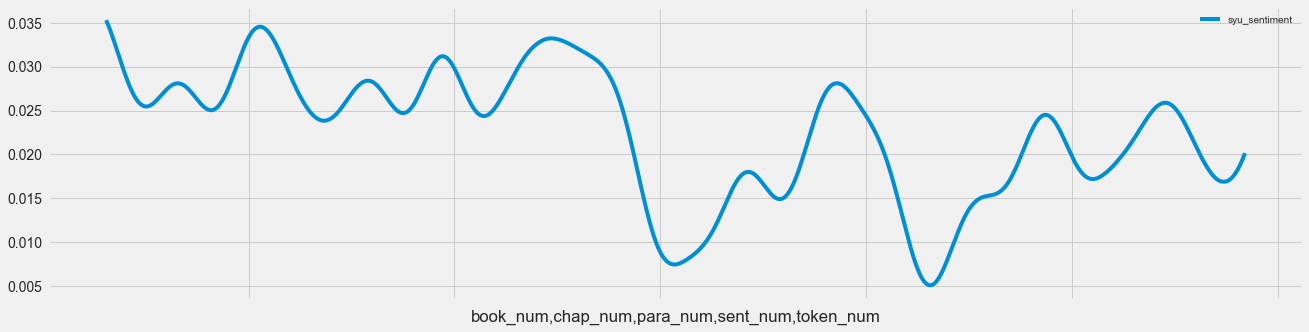

In [161]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

## Peak Joy

### Find max joy from PLOTS

In [162]:
PLOTS.head()

emo,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.000371,0.000479,0.000469,0.000335,0.000514,0.000366,0.000505,0.000287,0.000535,0.000473,0.000408,0.000530,0.000530,0.000525,0.000562
1,0.000387,0.000499,0.000488,0.000349,0.000537,0.000380,0.000527,0.000299,0.000558,0.000496,0.000425,0.000554,0.000554,0.000547,0.000585
2,0.000402,0.000519,0.000507,0.000362,0.000561,0.000394,0.000550,0.000311,0.000581,0.000519,0.000442,0.000578,0.000578,0.000570,0.000608
3,0.000418,0.000540,0.000525,0.000376,0.000585,0.000407,0.000573,0.000323,0.000604,0.000542,0.000459,0.000602,0.000602,0.000593,0.000632
4,0.000434,0.000560,0.000543,0.000390,0.000609,0.000421,0.000596,0.000335,0.000628,0.000566,0.000476,0.000627,0.000627,0.000615,0.000655


In [163]:
PEAK_JOY = int((PLOTS['nrc_joy'].idxmax() / 1000) * tokens.shape[0])

In [164]:
PEAK_JOY_CHAP_NUM = tokens.iloc[PEAK_JOY].name[1]

In [165]:
PEAK_JOY_CHAP_NUM # the chapter where peak joy appeared

22

### Display Chapter

In [166]:
PEAK_JOY_CHAP = tokens.reset_index()[tokens.reset_index().chap_num==PEAK_JOY_CHAP_NUM].groupby(['para_num']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [167]:
display(HTML('<br/><br/>'.join(PEAK_JOY_CHAP)))

## Experimental Plotting Function

In [168]:
def  plot_sentiment(emo_col, type='sent'):
    if type == 'sent':
        by_sent[emo_col].fillna(0).rolling(**CFG1).mean().plot(**FIG)
    elif type == 'tokens':
        tokens[emo_col].fillna(0).rolling(**CFG2).mean().plot(**FIG)
    elif type == 'kde':
        PLOTS[emo_col].plot(**FIG)
    else:
        pass

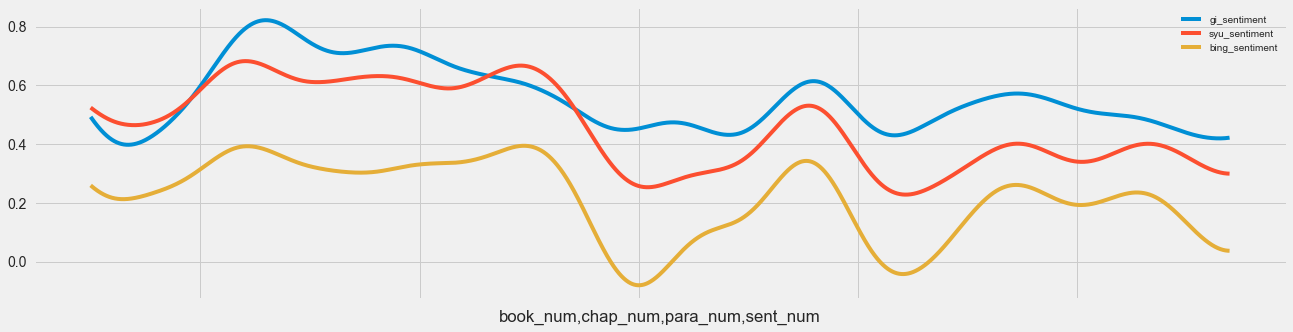

In [169]:
plot_sentiment('gi_sentiment')
plot_sentiment('syu_sentiment')
plot_sentiment('bing_sentiment')

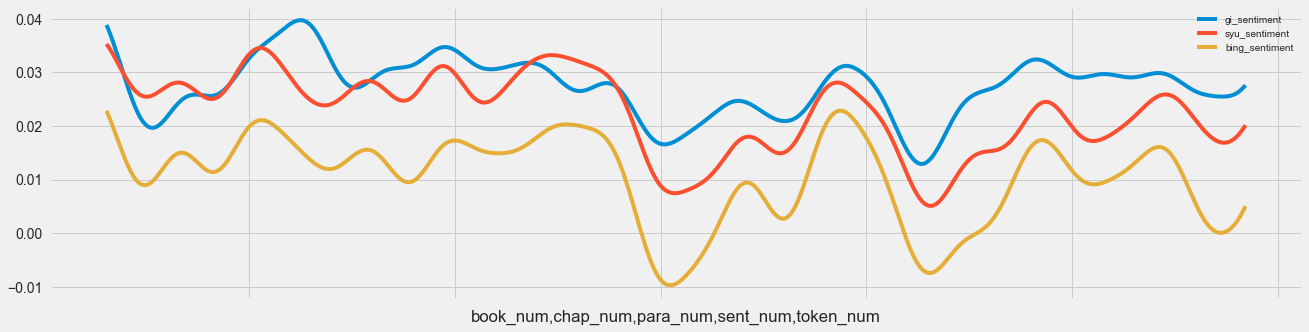

In [170]:
plot_sentiment('gi_sentiment', type='tokens')
plot_sentiment('syu_sentiment', type='tokens')
plot_sentiment('bing_sentiment', type='tokens')

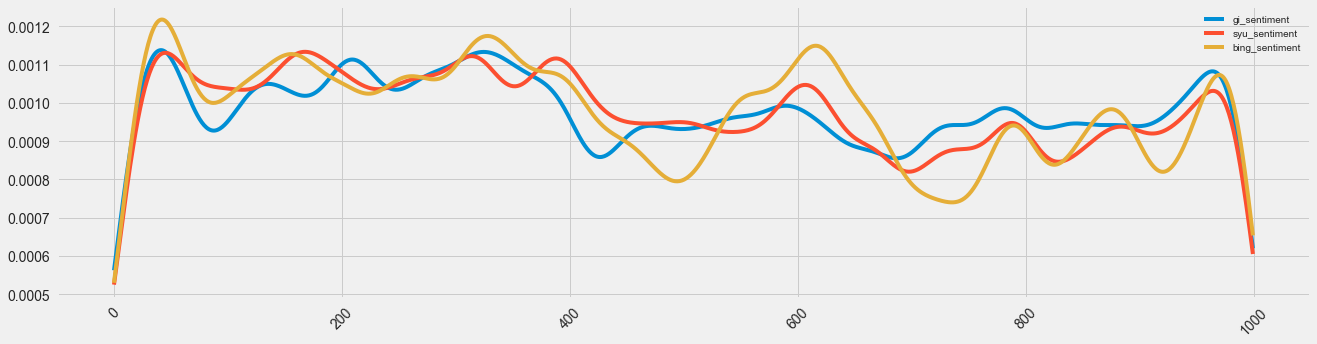

In [171]:
plot_sentiment('gi_sentiment', type='kde')
plot_sentiment('syu_sentiment', type='kde')
plot_sentiment('bing_sentiment', type='kde')

In [172]:
# End